In [4]:
import numpy as np
import mesa_reader as mr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.ticker as ticker
import pandas as pd
import scipy

import scienceplots
plt.style.use('science')

plt.rcParams.update({'font.size': 11})

In [5]:
h1 = mr.MesaData("low_mass_exercise2/LOGS/history.data")
h2 = mr.MesaData("low_mass_with_h2/LOGS/history.data")

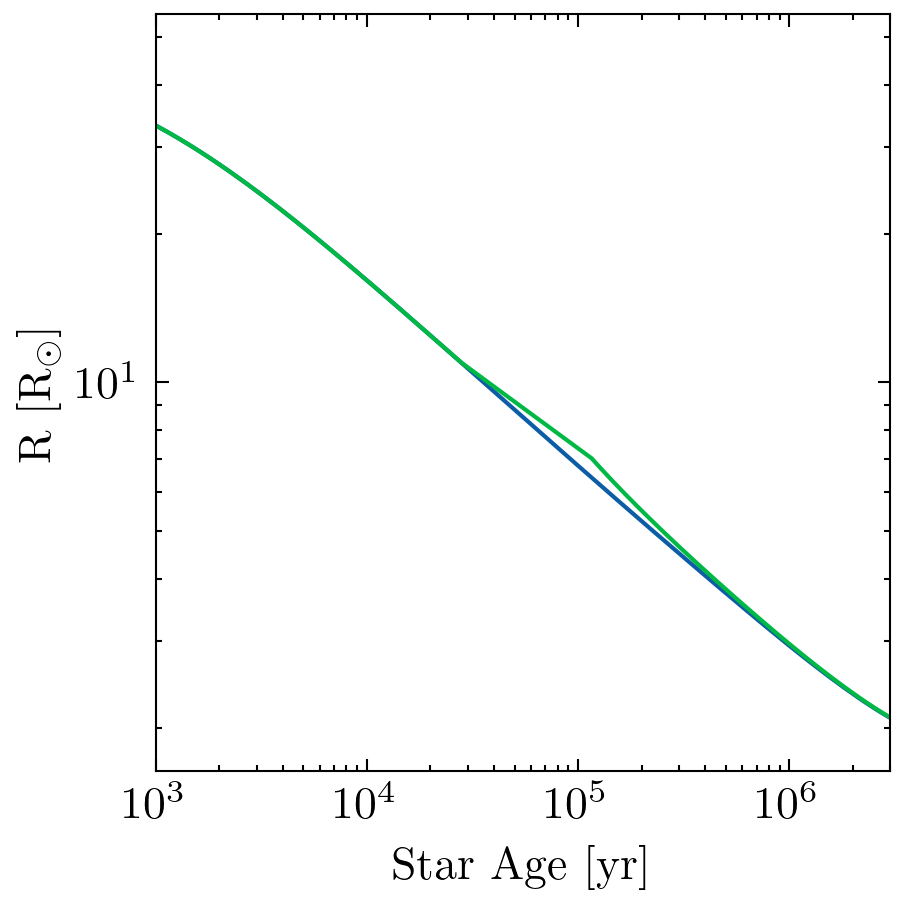

In [73]:
mask1 = h1.log_Lnuc / h1.log_L < 1e-6
mask2 = h2.log_Lnuc / h2.log_L < 1e-6

radius1 = 10**h1.log_R[mask1]
radius2 = 10**h2.log_R[mask2]

star_age1 = h1.star_age[mask1]
star_age2 = h2.star_age[mask2]

fig, ax = plt.subplots(figsize=(3, 3), sharex=True, dpi=300, layout="constrained")

ax.loglog(star_age1, radius1, c="C0")
ax.loglog(star_age2, radius2, c="C1")

ax.set_xlabel("Star Age [yr]")
ax.set_ylabel("R [R$_\odot$]")

ax.set_xlim(1e3, 3e6)

fig.savefig("../plots/q42_radius_vs_age.pdf", bbox_inches='tight')

### Q.4.3

In [60]:
l = mr.MesaLogDir("low_mass_with_h2/LOGS")

In [61]:
# Define predicate function
def hot_core(logT, star_age):
    return logT > 6  # logT in Kelvin, star_age in seconds

model_nums = l.select_models(hot_core, 'log_center_T', 'star_age')



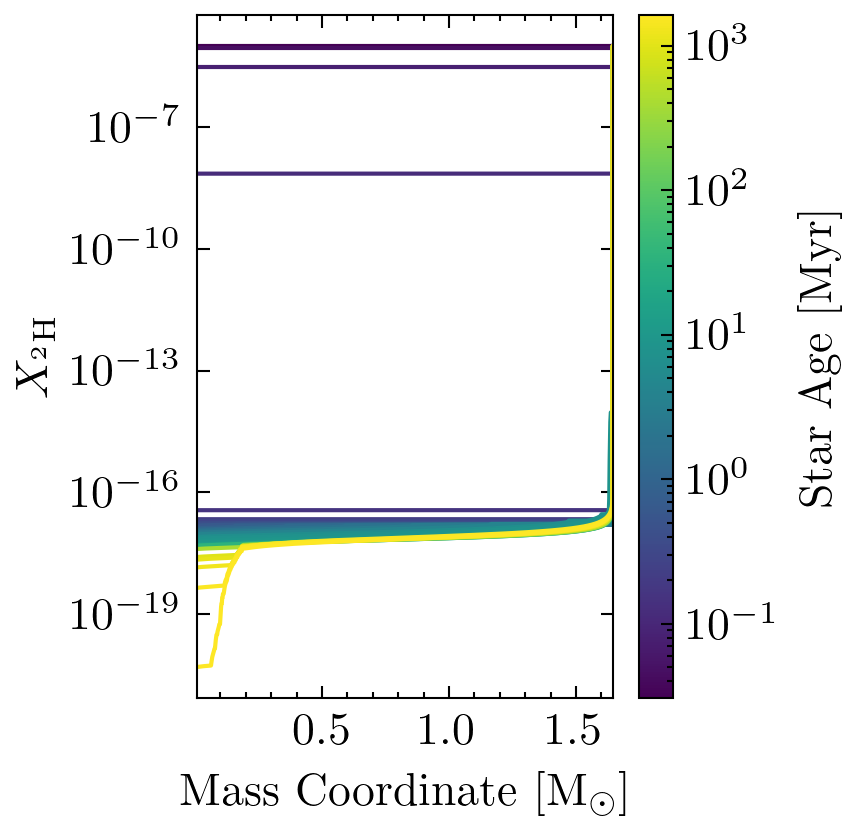

In [75]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
# Collect ages for color mapping
ages_for_color = []
profiles = []
for prof in model_nums[1:]:
    data = l.profile_data(model_number=prof)
    profiles.append(data)
    ages_for_color.append(data.header('star_age') / 1e6)  # Convert to Myr

ages_for_color = np.array(ages_for_color)

norm = LogNorm(vmin=ages_for_color.min(), vmax=ages_for_color.max())
cmap = plt.get_cmap('viridis')

for data, age in zip(profiles, ages_for_color):
    inner_mask = data.mass < 2
    ax.plot(data.mass[inner_mask], data.h2[inner_mask], color=cmap(norm(age)))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label="Star Age [Myr]")

ax.set_xlim(0.01, data.mass.max())
ax.set_xlabel("Mass Coordinate [M$_\odot$]")
ax.set_ylabel(r"$X_{^2\mathrm{H}}$")
ax.set_yscale('log')
plt.tight_layout()
plt.show()

fig.savefig("../plots/q42_h2_profile.pdf", bbox_inches='tight')

C:\Users\bruno\AppData\Local\Temp\ipykernel_27288\2576625175.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(3, 3), dpi=300, tight_layout=True)


Error in callback <function _draw_all_if_interactive at 0x00000134AD33C220> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

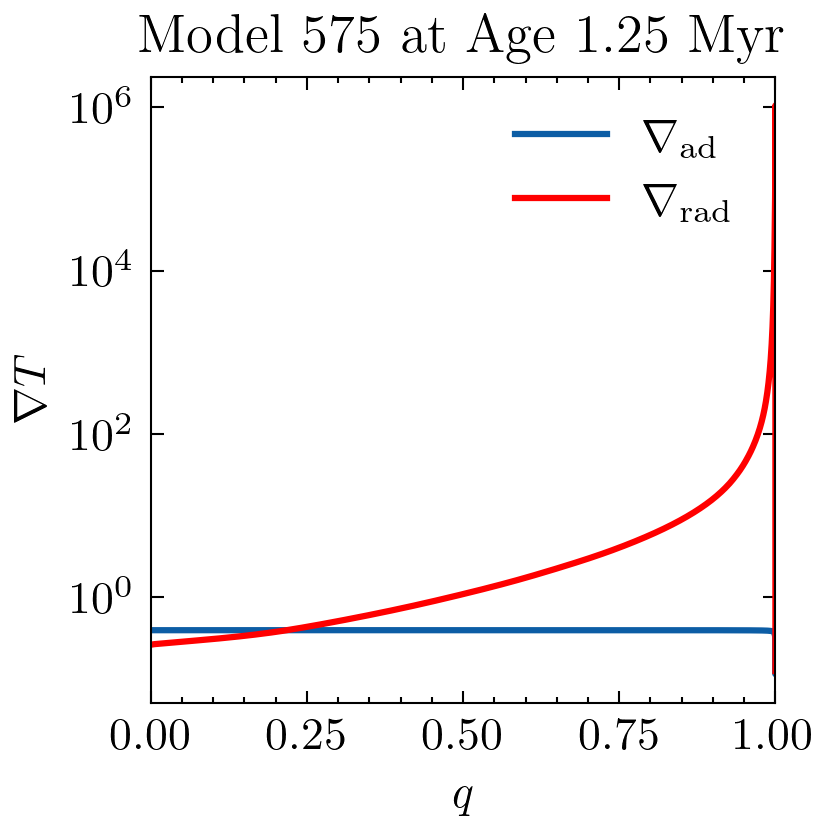

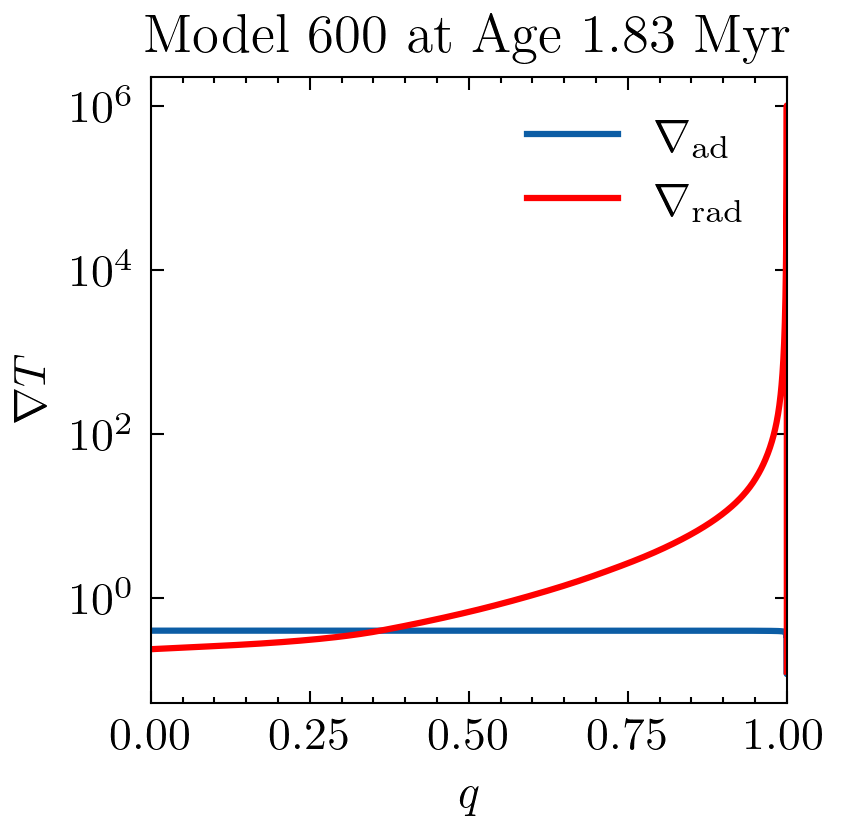

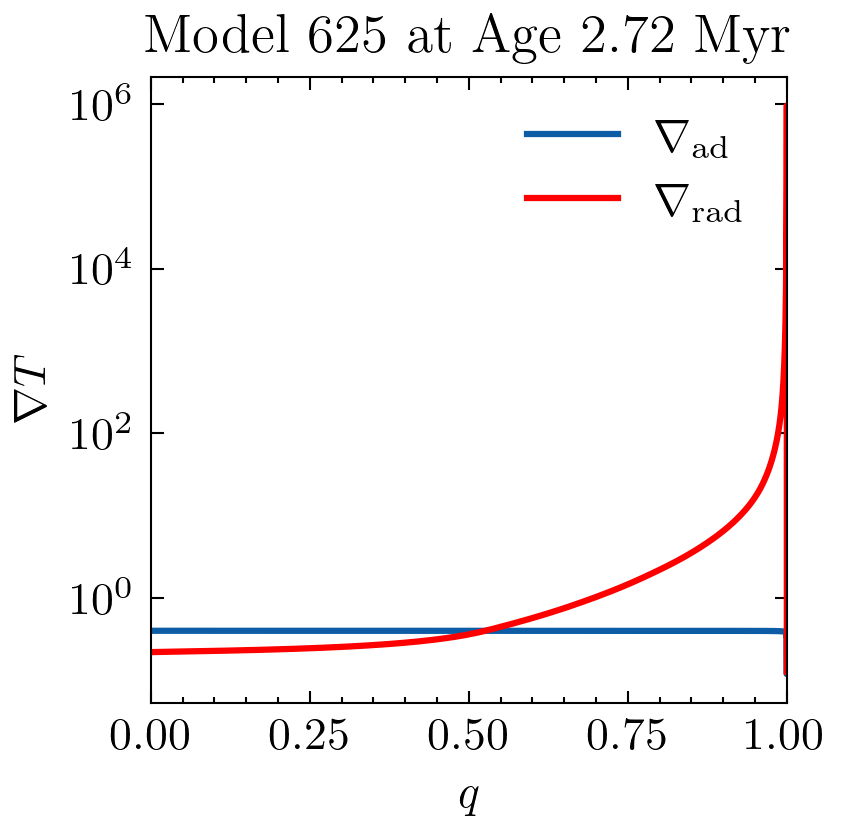

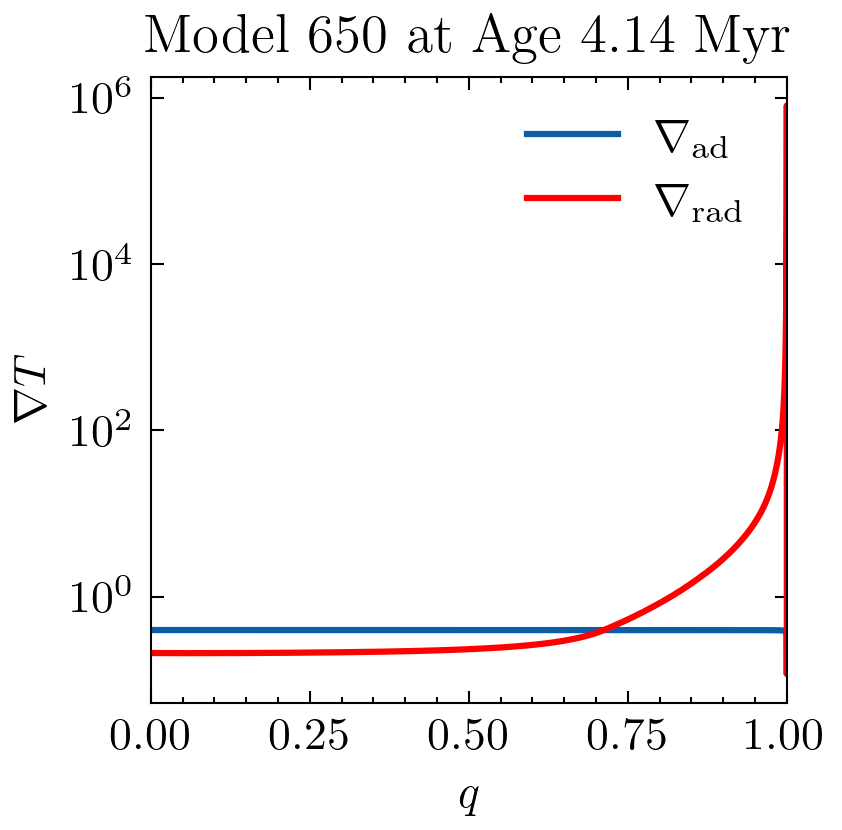

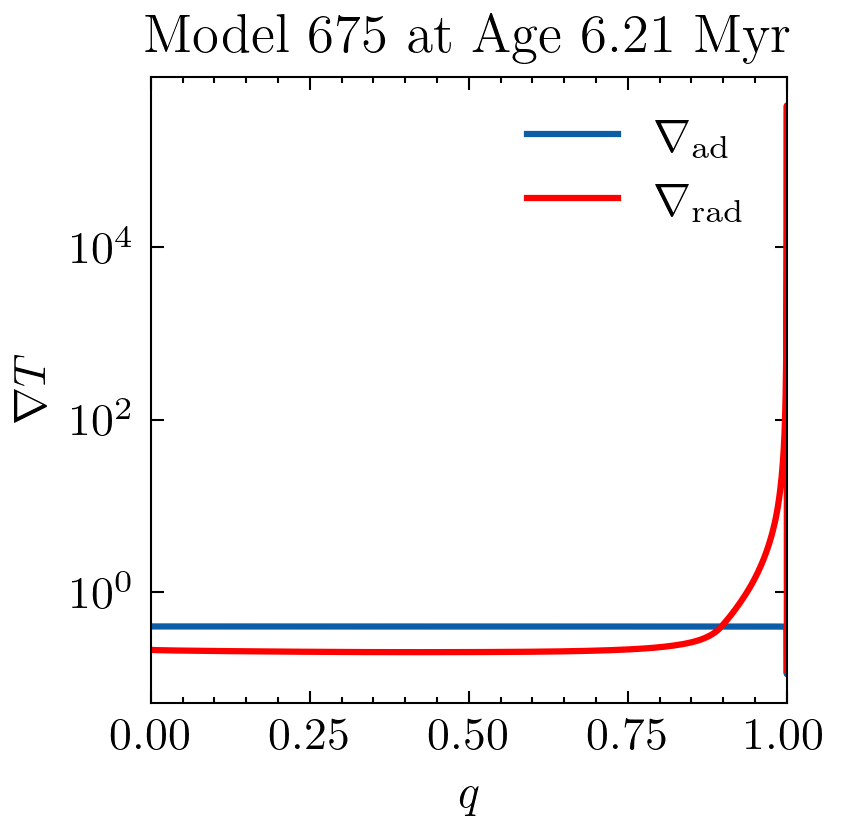

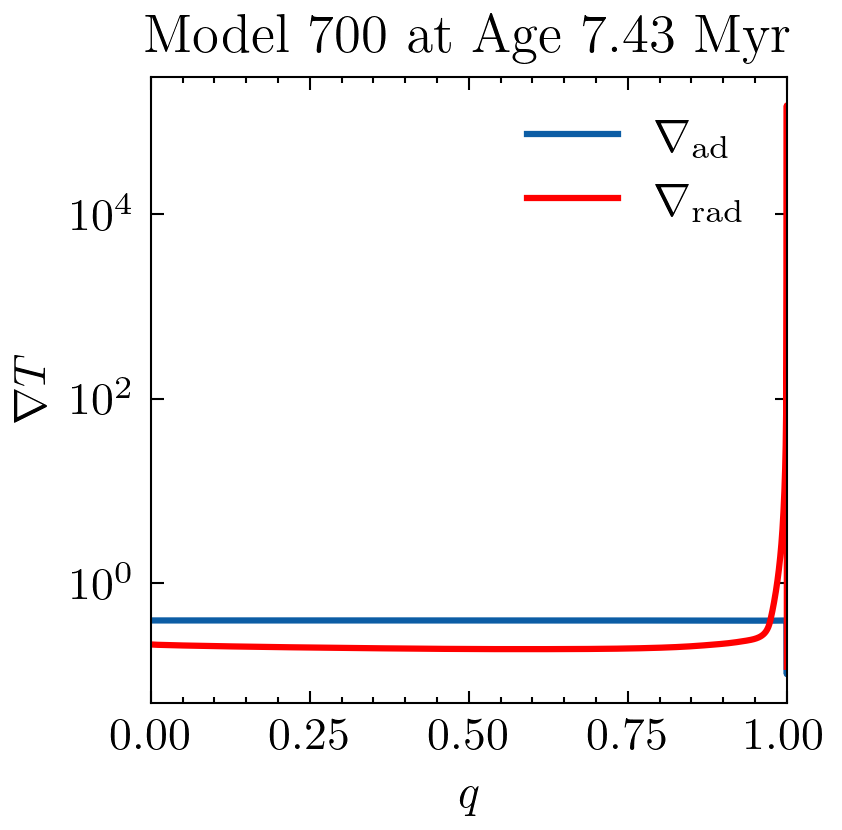

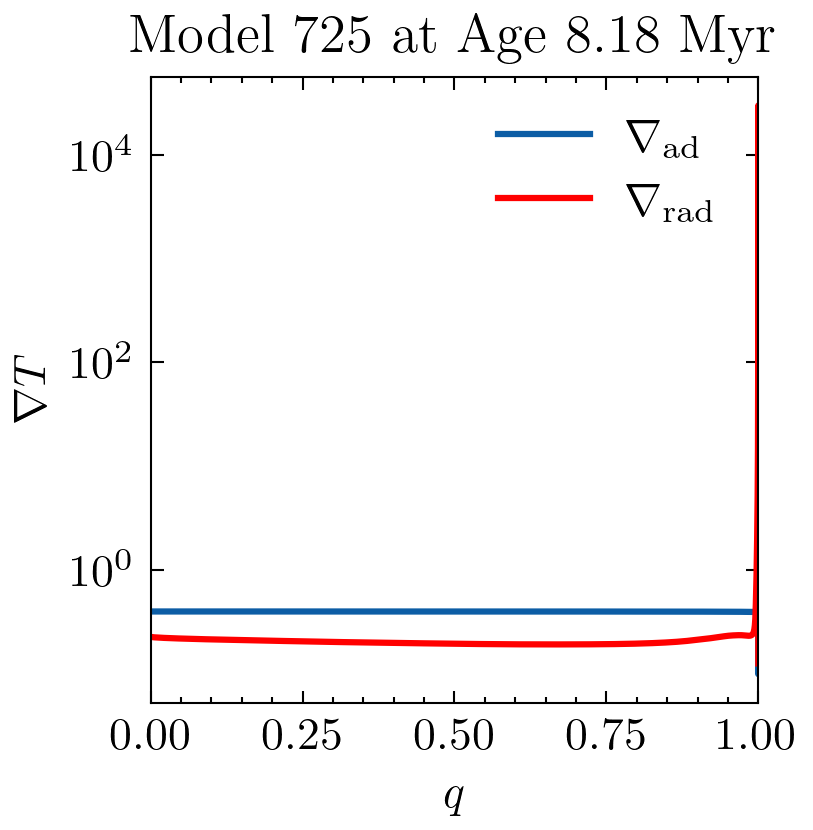

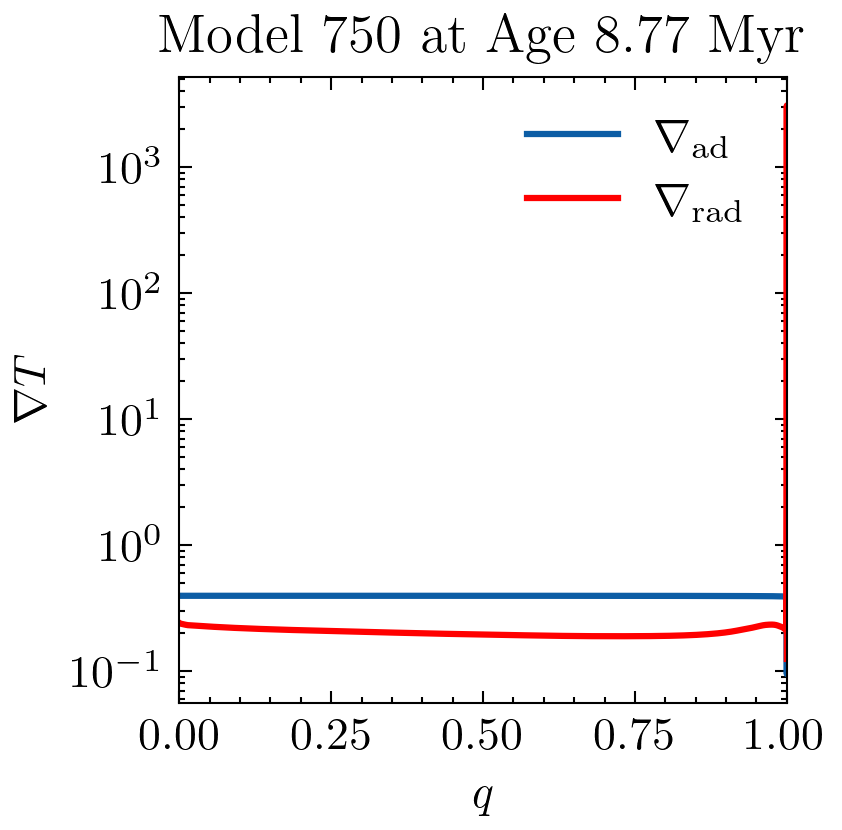

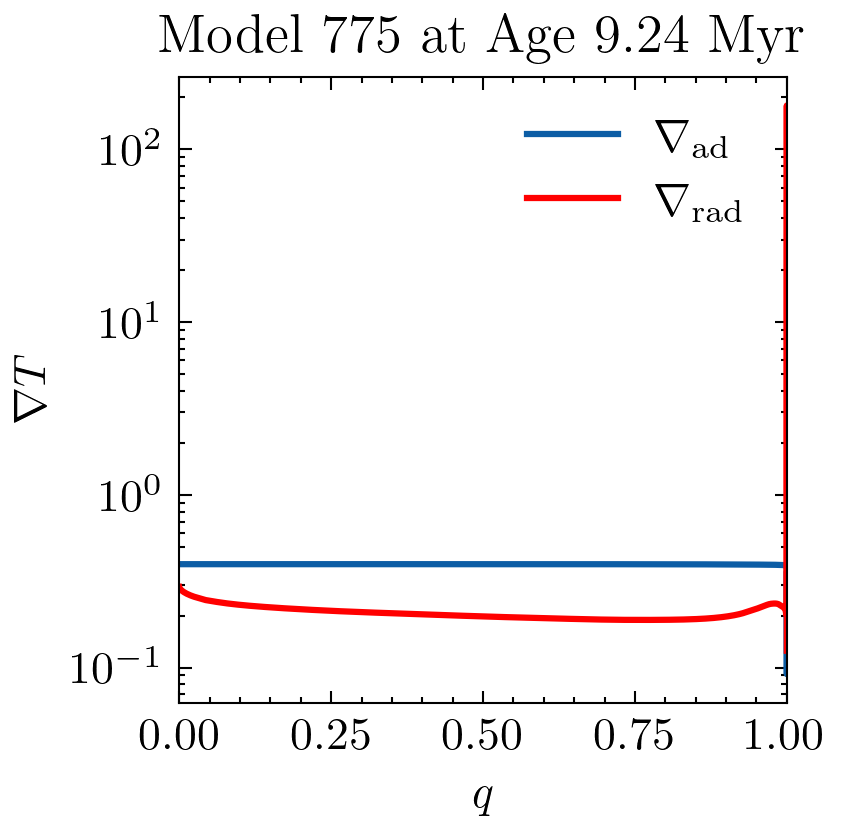

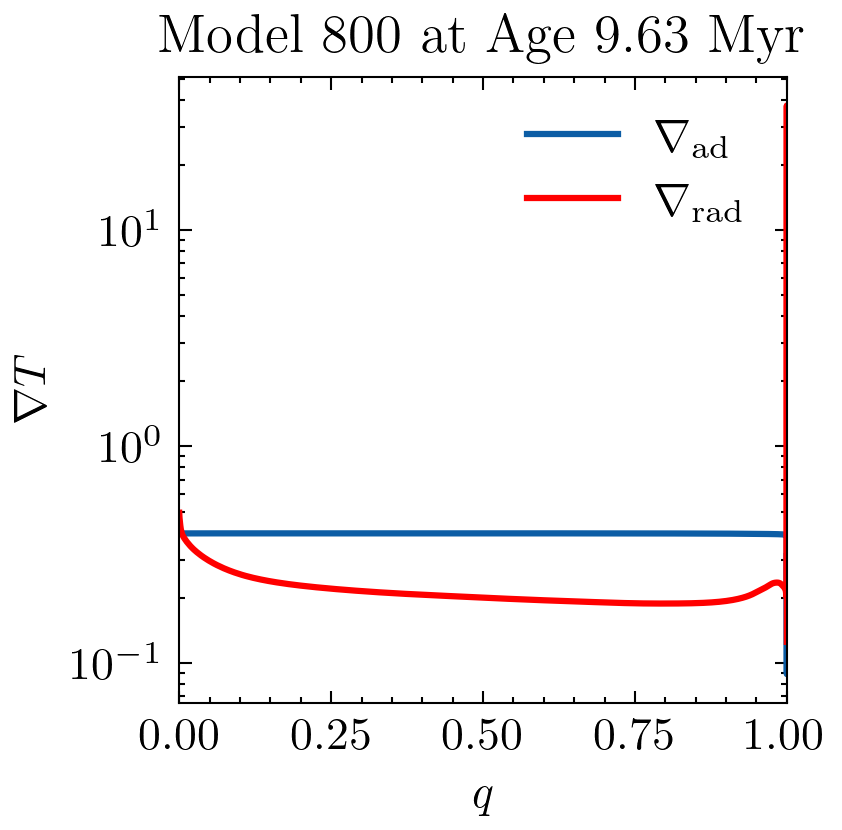

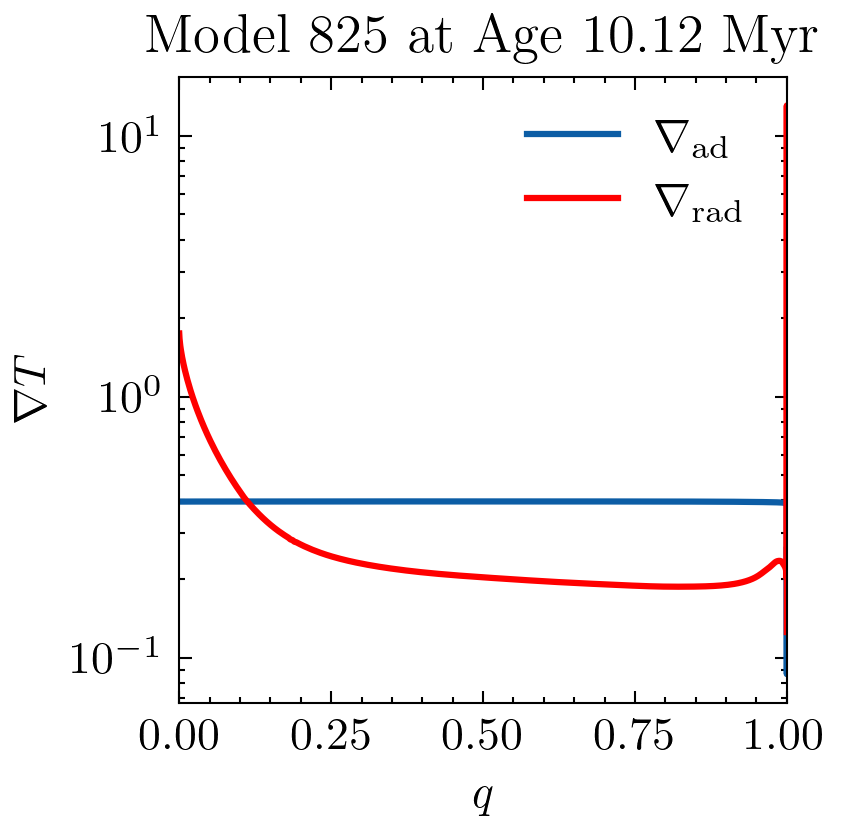

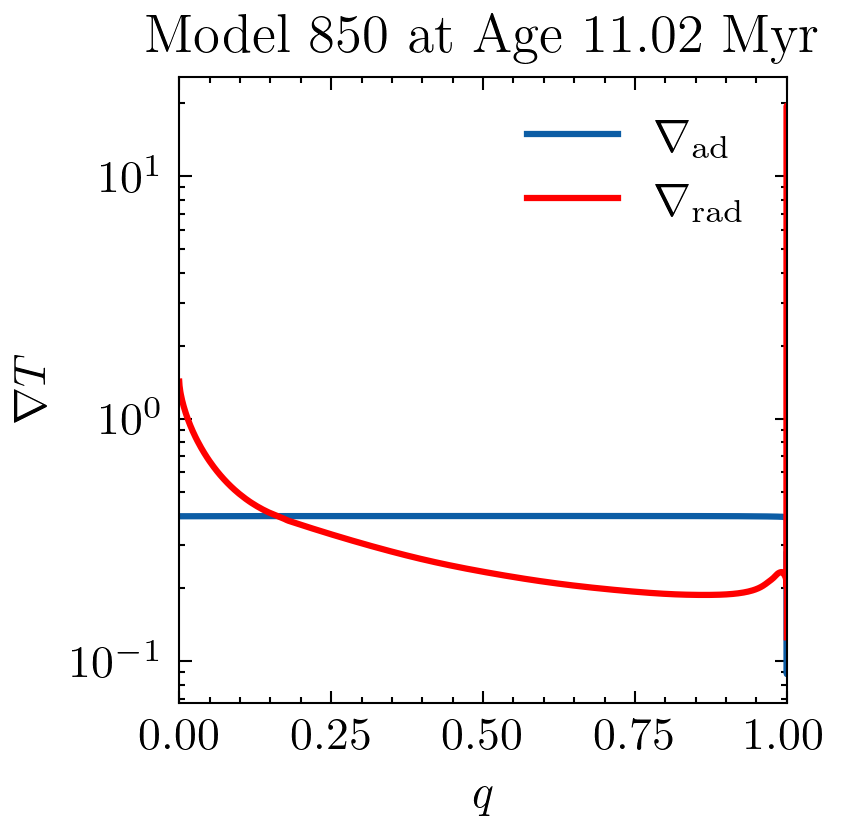

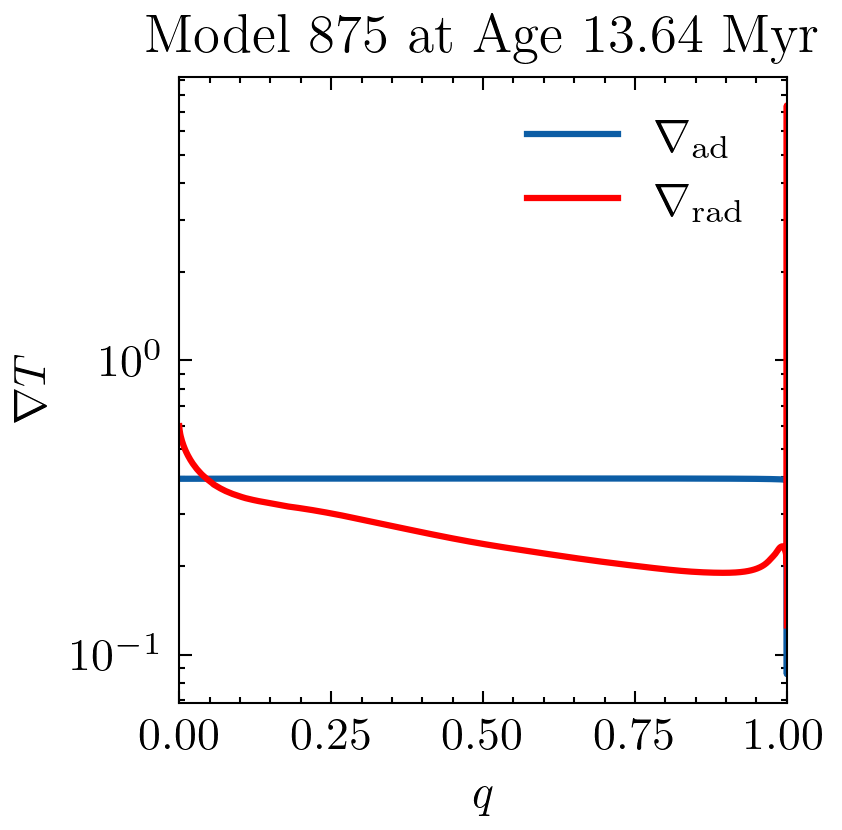

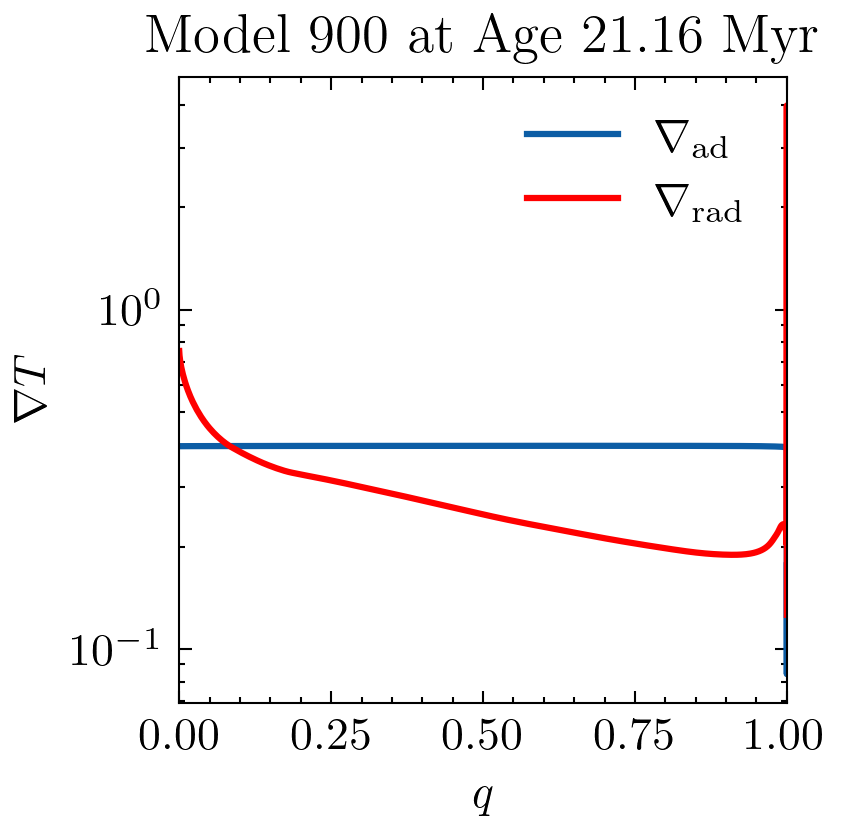

: 

: 

In [ ]:
# Define predicate function
def hot_core(logT, star_age):
    return logT > 6 and star_age > 1e6 # logT in Kelvin, star_age in seconds

model_nums = l.select_models(hot_core, 'log_center_T', 'star_age')


for model_num in model_nums:
    data = l.profile_data(model_number=model_num)

    fig, ax = plt.subplots(figsize=(3, 3), dpi=300, tight_layout=True)

    ax.plot(data.q, data.grada, color='C0', lw=1.5, label=r'$\nabla_{\text{ad}}$')
    ax.plot(data.q, data.gradr, color='r', lw=1.5, label=r'$\nabla_{\text{rad}}$')

    ax.set_xlim(0, 1)

    ax.set_xlabel(r'$q$')
    ax.set_ylabel(r'$\nabla T$')
    ax.legend(loc='upper right', frameon=False, fontsize=11)
    ax.set_yscale('log')

    ax.set_title(f"Model {model_num} at Age {data.header('star_age') / 1e6:.2f} Myr")

### Q4.4.

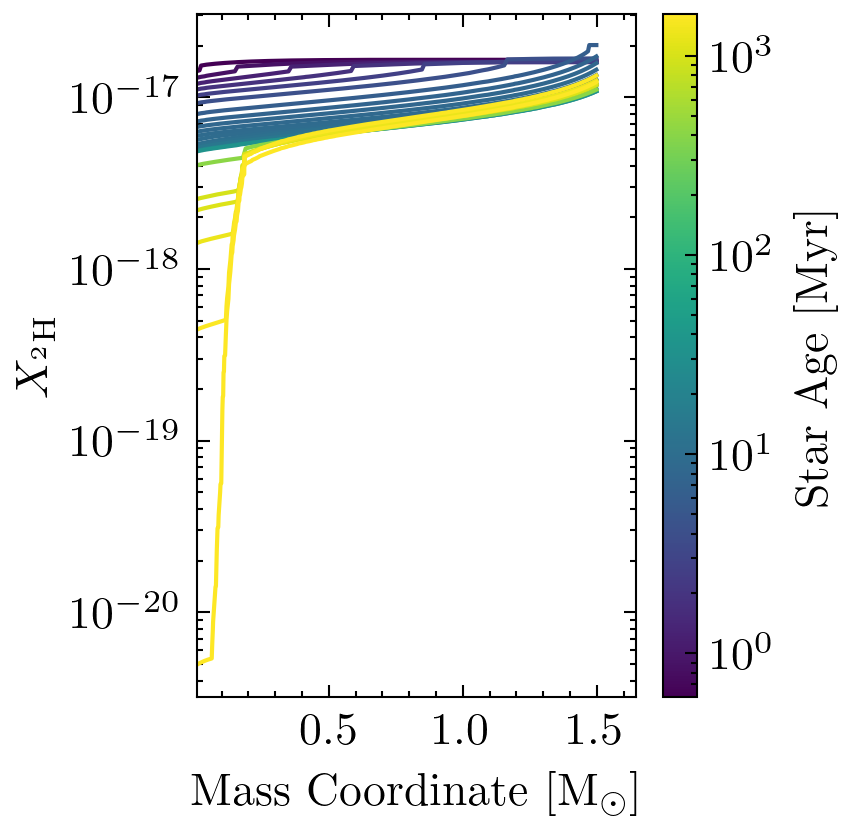

In [84]:

def hot_core(logT, star_age):
    return 10**logT > 3 * 10**6  # logT in Kelvin, star_age in seconds

model_nums_new_universe = l.select_models(hot_core, 'log_center_T', 'star_age')

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
# Collect ages for color mapping
ages_for_color = []
profiles = []
for prof in model_nums_new_universe[1:]:
    data = l.profile_data(model_number=prof)
    profiles.append(data)
    ages_for_color.append(data.header('star_age') / 1e6)  # Convert to Myr

ages_for_color = np.array(ages_for_color)

norm = LogNorm(vmin=ages_for_color.min(), vmax=ages_for_color.max())
cmap = plt.get_cmap('viridis')

for data, age in zip(profiles, ages_for_color):
    inner_mask = data.mass < 1.5
    ax.plot(data.mass[inner_mask], data.h2[inner_mask], color=cmap(norm(age)))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label="Star Age [Myr]")

ax.set_xlim(0.01, data.mass.max())
ax.set_xlabel("Mass Coordinate [M$_\odot$]")
ax.set_ylabel(r"$X_{^2\mathrm{H}}$")
ax.set_yscale('log')
plt.tight_layout()
plt.show()

fig.savefig("../plots/q42_h2_profile_new_universe.pdf", bbox_inches='tight')